# Predicting Heart Disease in Patients
-- Applied Machine Learning Midterm Fall 2025 --

**Name:** Karli Dean\
**Date:** November 11, 2025

**Purpose:** Heart conditions and diseases run rampant throughout the United States. So, much that 1 in 3 deaths in the United States are related to a heart condition, making it the leading cause of death in most racial and ethnic groups, according to the [CDC](https://www.cdc.gov/heart-disease/data-research/facts-stats/index.html). Heart disease is something near and dear to my own heart (no pun intended) as it is something I am at risk of genealogically. My grandfather was many a victim to heart attacks, and I have other family members who suffer from diabetes, which can affect the heart due to misregulation of sugar in the blood. This classification analysis will make for a way to understand if someone is at risk for this kind of health concern.

## Section 1 - Imports

### Section 1.1  - Standard Python Library Imports
These are all of the packages and imported tools I've used in this analysis.

In [100]:
# Importing Packages from the Python Library
import pandas as pd
import pathlib
from pathlib import Path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

### Section 1.2 - Importing and Inspecting the Data Set
#### Section 1.2.1 - Importing the Data from the Internet
This is the heart disease data set from the [UC - Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/45/heart+disease). A detailed description of all of our features can be found in the [README.md]().

In [88]:
from ucimlrepo import fetch_ucirepo

# Assume notebook lives in repo_root/notebooks/
repo_root = pathlib.Path().resolve().parent
raw_data_dir = repo_root / "data" / "raw"
raw_data_dir.mkdir(parents=True, exist_ok=True)

print("DATA CAPTURE PROCESS STATUS: INITIALIZATION: SAVING DATA TO:", raw_data_dir)

# Fetch dataset
heart_disease = fetch_ucirepo(id=45)
X = heart_disease.data.features
y = heart_disease.data.targets

# Combine feature + target for easier analysis
df = pd.concat([X, y], axis=1)

# Save to the correct folder (regardless of where your notebook lives)
df.to_csv(raw_data_dir / "heart_disease.csv", index=False)

print("DATA CAPTURE PROCESS STATUS: COMPLETE: SAVED DATA TO:", raw_data_dir / "heart_disease.csv")

DATA CAPTURE PROCESS STATUS: INITIALIZATION: SAVING DATA TO: C:\Repos\ml-classification-karlidean\data\raw
DATA CAPTURE PROCESS STATUS: COMPLETE: SAVED DATA TO: C:\Repos\ml-classification-karlidean\data\raw\heart_disease.csv


#### Section 1.2.2 - Inspecting the Data Set with the `.head()` Function
Now that our data is loaded into our raw data folder, we can inspect it to see what it looks like and what kinds of features there are. Let's use the `.head()` function to look at those first 10 rows of our DataFrame (labeled df).

In [89]:
# Using the .head() function
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
5,56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
6,62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3
7,57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0
8,63,1,4,130,254,0,2,147,0,1.4,2,1.0,7.0,2
9,53,1,4,140,203,1,2,155,1,3.1,3,0.0,7.0,1


#### Section 1.2.3 - Inspecting the data with the `.isnull()` Function
Cool! We can now see the DataFrame! Now, we're going to use the `.isnull()` function to see how many missing values there are. What makes this function really cool is that this function will tell us what feature houses the null records.

In [90]:
# Using the .isnull() function
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64

## Reflection 1 - 
1. What do you notice about the dataset? The first thing I noticed is the data is all numerical. Being without categorical data can aid in some models, but hurt us in other models. Items like linear regressions are common with all-numerical data, but we can still run items like confusion matrices.
2. Are there any data issues? The data looks pretty standardized from a float view in the head, but there are some missing values in the `ca` and `thal` fields. The ca is the number of colored vessels and the thal (likely meaning thalassemia), which is an inherited blood disorder that can cause cardiac complications.

## Section 2 - Data Exploration and Preparation
In this section, we will be looking at models to see if there are any trends between features and handling our missing values in the set. This preparation makes our data easier to work with, so we call it feature engineering!

### Section 2.1 - Explore Data Patterns and Distributions
This part of data exploration is very fun because we get to look at pretty pictures and tell people what they mean. We're going to create boxplots and pariplots to visualize this.

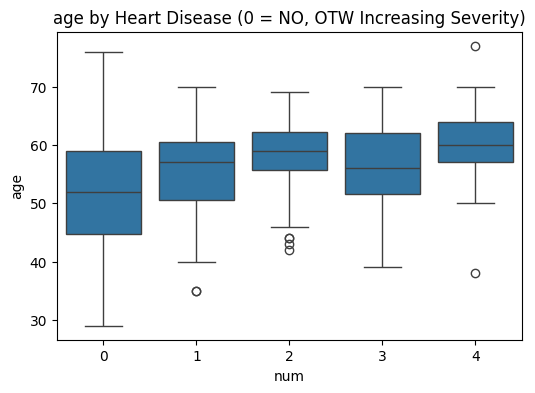

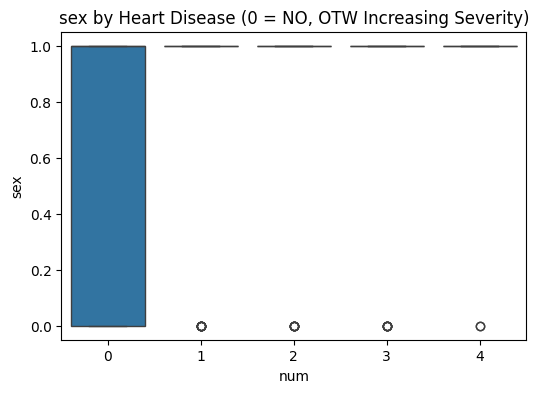

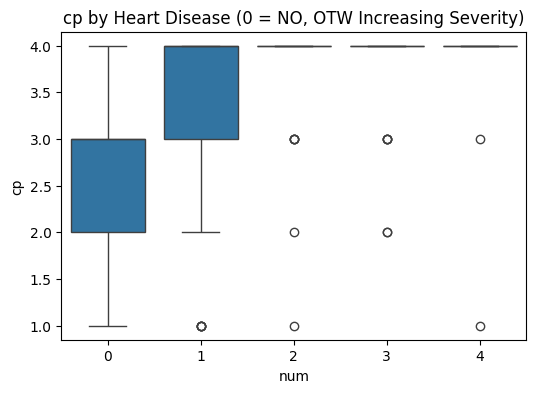

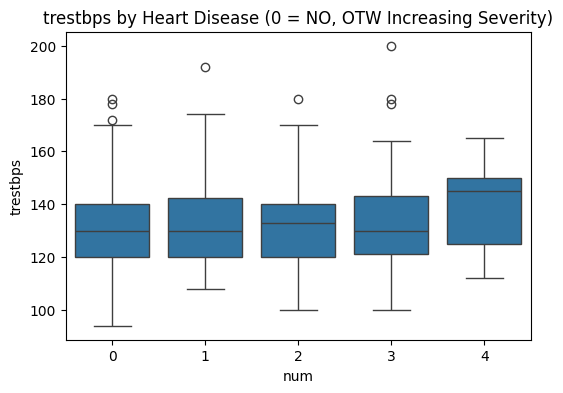

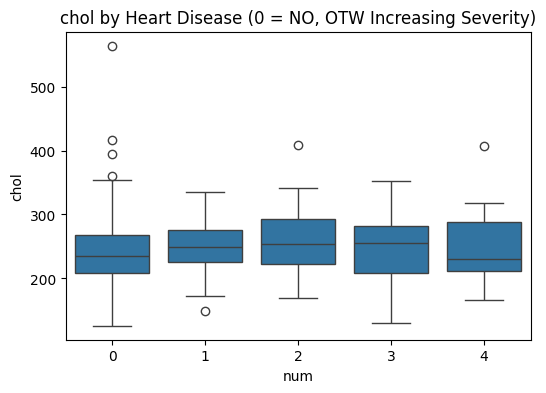

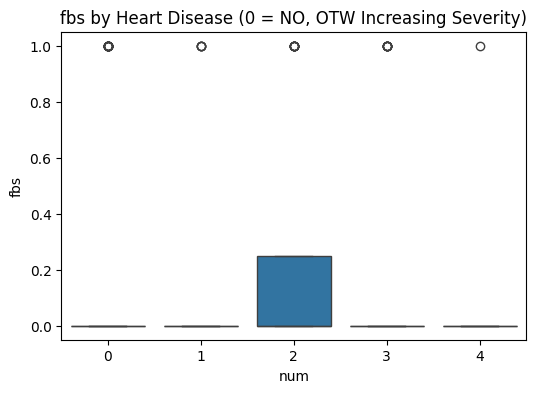

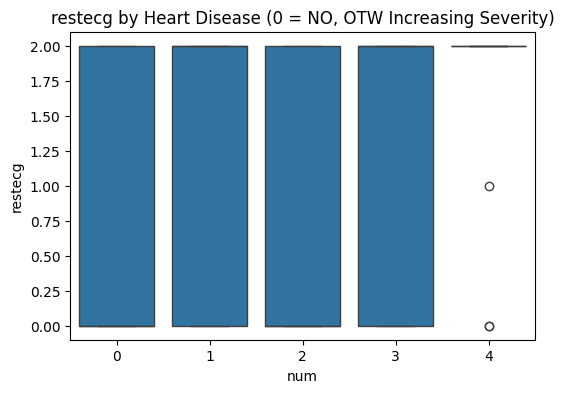

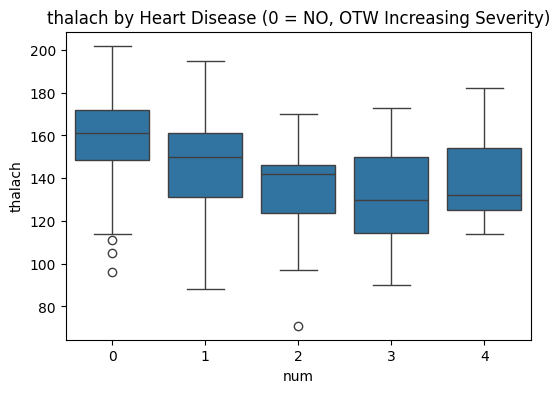

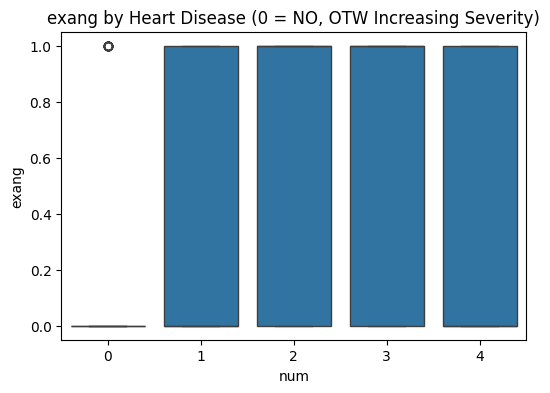

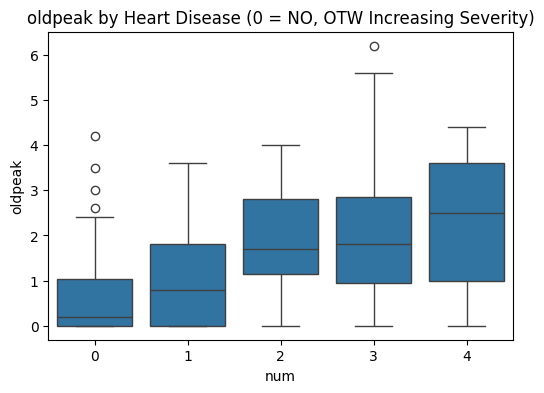

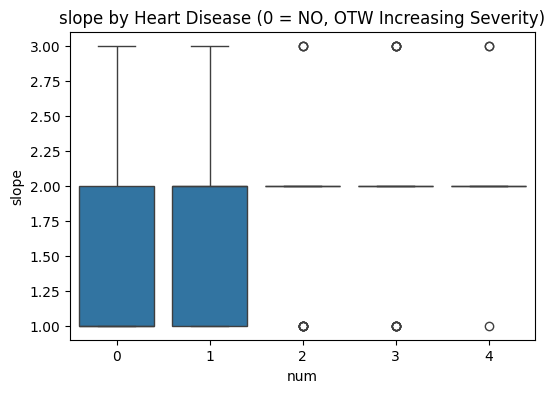

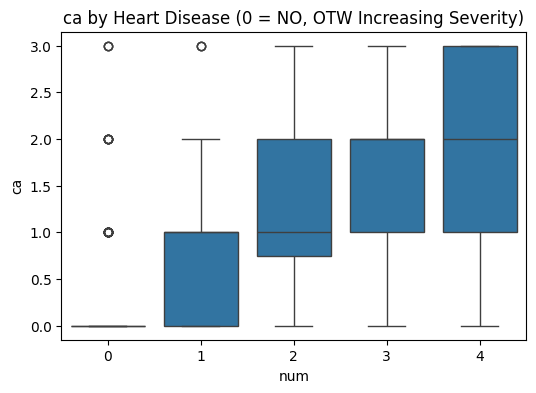

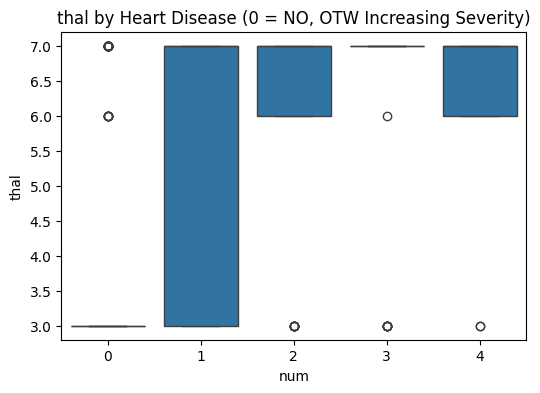

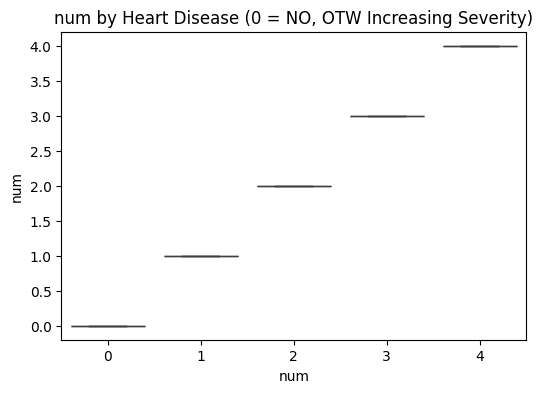

In [91]:
# Creating boxplots
for col in df:
    plt. figure(figsize=(6,4))
    sns.boxplot(x="num", y=col, data=df)
    plt.title(f'{col} by Heart Disease (0 = NO, OTW Increasing Severity)')
    plt.show

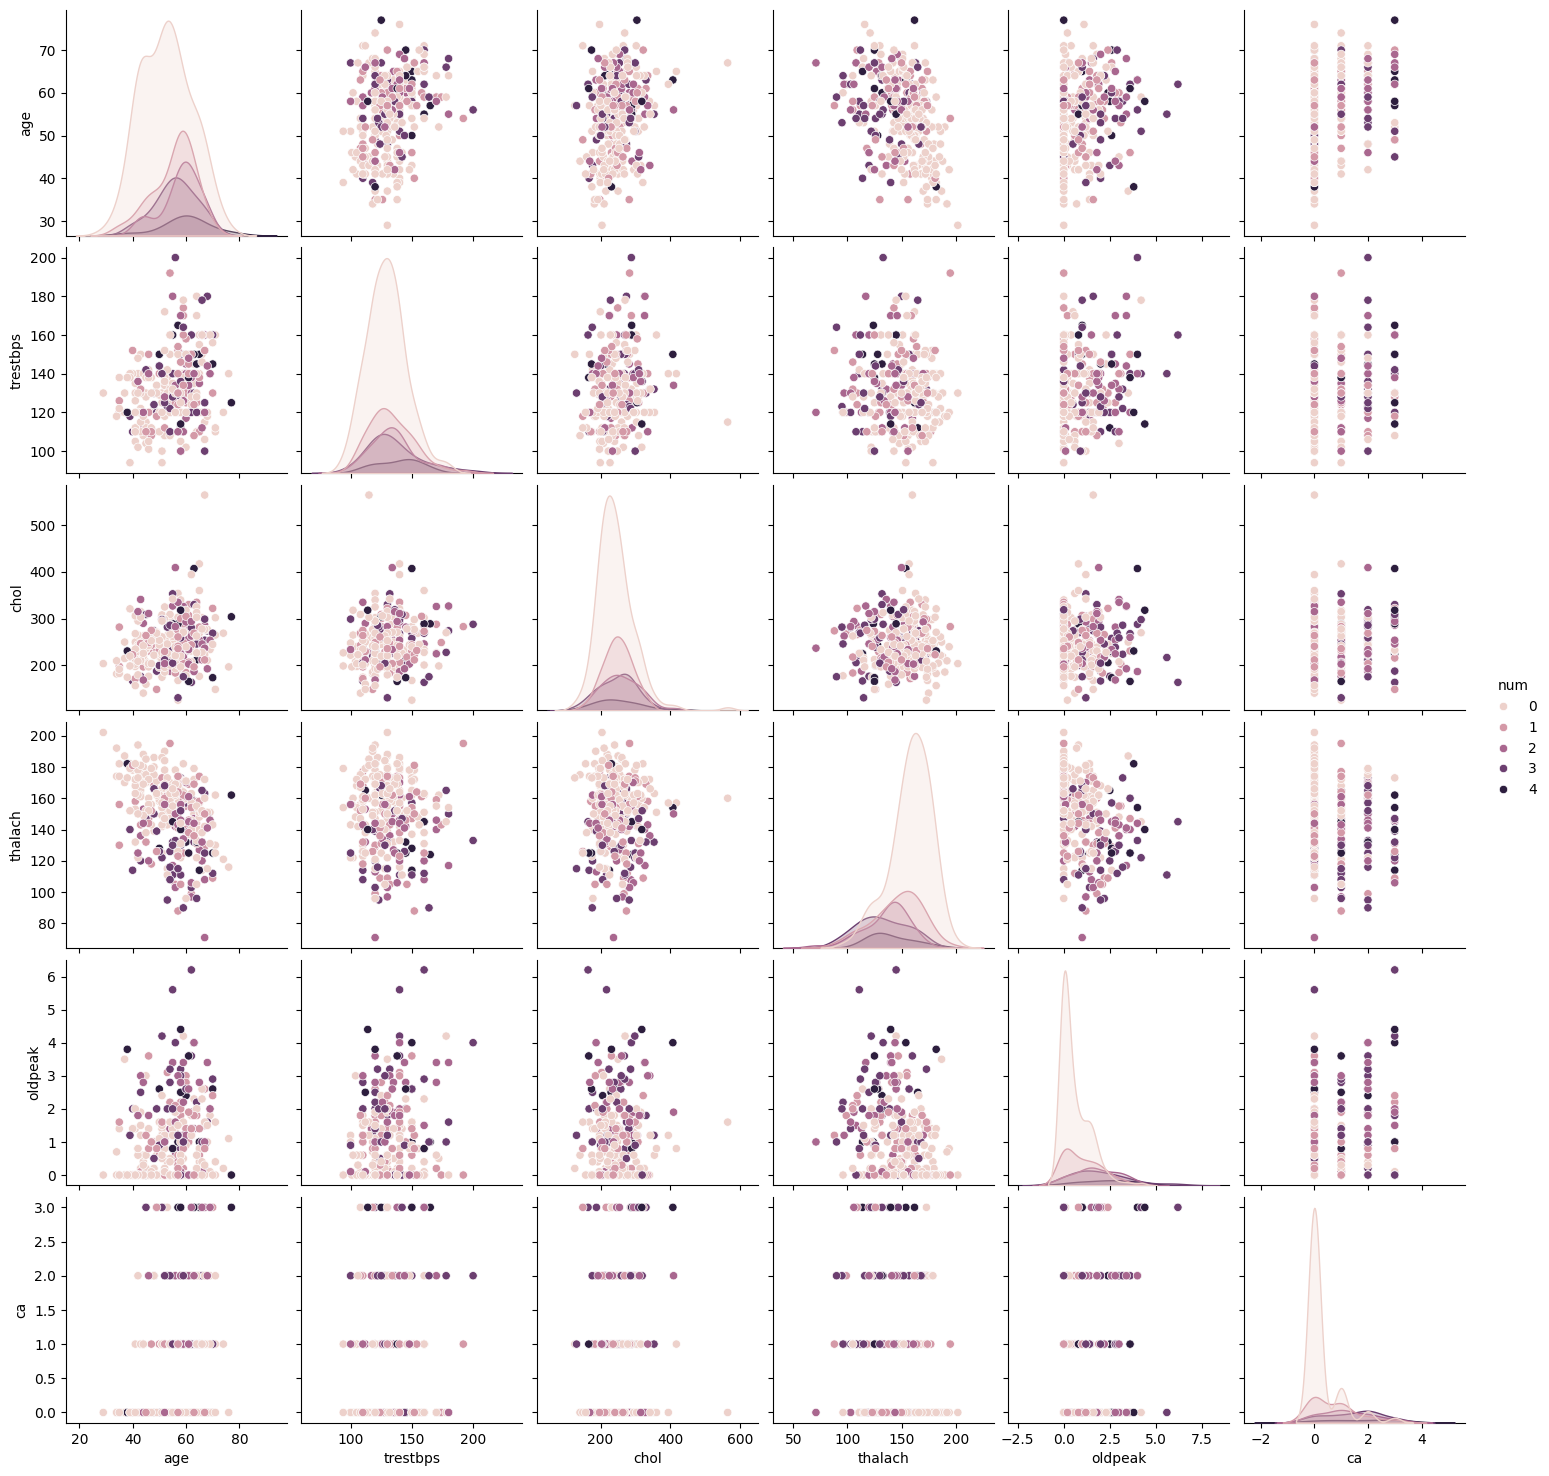

In [92]:
# Creating a pairplot series of the data I want to evaluate
sns.pairplot(df[['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'num']], hue='num')

### Section 2.2 - Handling Missing Values and Cleaning Data
This section is more on feature engineering, which will make our data easier to understand as we plot items and try to analyze. We will be filling in any numerical (non-binary keys) with a median value, and binary keys with the most-occurring result in the feature. I understand this can cause noise in the graph, however, it is a way to clean the data that can introduce the "one-in-a-million" record who has everything that should point to heart disease, but the patient is clean.

In [93]:
# Imputing Missing Values

# Numerical Features
# Can be features that have fractional properties
num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Numerical Coded Categorical Features with mode
# This is because you can't have half a man/woman or half of a chest pain type
cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

In [94]:
# Removing Outliers

# Computing Z-Scores
z_scores = np.abs((df[num_cols] - df[num_cols].mean()) / df[num_cols].std())

# New DF without outliers.
# In this project, this is anything outside of 2 sd's away from average.
# Data Frame No Outliers (DFNO)
dfno = df[(z_scores <2).all(axis = 1)]

dfno = dfno.copy()

dfno.shape, df.shape

((245, 14), (303, 14))

In [95]:
dfno.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1


### Section 2.3 - Feature Selection and Engineering
Covering the bulk of feature engineering, we should have now realized what features we want to measure to predict our target feature (Heart Disease, with or without?). Now, we will make our features easier to comprehend and create new features where applicable.

In [96]:
# Feature Engineering

# Making the target (previously called num) a binary value
dfno['target'] = dfno['num'].apply(lambda x: 1 if x > 0 else 0)

# Removing any feature I am not focusing on for the target
dfno = dfno.drop([
    'sex',
    'cp',
    'fbs',
    'restecg',
    'exang',
    'slope',
    'thal',
    'num'
],
axis = 1)


In [97]:
# Checking the shape of our new DF
dfno.shape

(245, 7)

## Reflection 2 - 
1. What patterns or anomalies do you see? I'm seeing trends where gender doesn't look like it matters in this determination. I am also seeing how things like an ecg's results don't matter as much as they can be of similar result with varying heart disease statuses.
2. Do any features stand out? The following features stand out in favor of being good predictors of whether or not heart disease would be present in the patient: age, trestbps, chol, thalach, oldpeak, and ca.
3. What preprocessing steps were necessary to clean and improve the data? To make this data workable towards my goal, I made my target field (previously num) binary, not based on severity. I removed any record outside of 2 standard deviations from the mean, and filled in any missing values with the median for numerical values and the mode for categorical values. Though the categories were numbers, they represented things like sex, which can't be partial credit of.
4. Did you create or modify any features to improve performance? I believe this was answered in question 3 as well, but my transformation removed the severities of heart disease, leaving it to 'heart disease or not'. I also removed data that did not show distribution. If it shows no difference against a target alone, how will it aid me in prediction?

## Section 3 - Feature Selection and Justification
This section allows us to put our data against itself and explain why it's the most important to predict this target.

### Section 3.1 - Choose Features and Target

#### Section 3.1.1 - Predicting Features
These are what will be predicting our target. Justify.

#### Section 3.1.2 - Target Variable
This is what we will be predicting. Justify.

### Section 3.2 - Define X and y
This allows us to mathematically solidify our choices of targets and predictors.

## Reflection 3 - 
1. Why did you choose these features?
2. How might they affect predictions or accuracy?

## Section 4 - Training a Model

### Section 4.1 - Splitting the Data
In order to create a model, we have to split our data into training and testing data.

### Section 4.2 - Training the Data
With the training data, we will build the model. We will then test the data

### Section 4.3 - Evaluating Model Performance

#### Section 4.3.1 - Testing the Model

#### Section 4.3.2 - Model Metrics and Performance

## Reflection 4 - 
1. How well did the model perform?
2. Are there any surprises in the results?

## Section 5 - Improve the Model

### Section 5.1 - Adjusting the Hyperparameters on the Model

### Section 5.2 - Model Comparison

## Reflection 5 - 
1. Which model performed better?
2. Why might one classifier be more effective in this specific case?

## Section 6 - Final Thoughts and Insights

### Section 6.1 - Summarizing My Findings

### Section 6.2 - What Challenges Were Faced?

### Section 6.3 - If I Had More Time, What Would I Try?

## Reflection 6 -
1. What did you learn from this project?